# NSLS 11-BM Calibration

### Import python libraries

In [170]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# numpy and plotting
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True,
                 'xtick.top': True,
                 'xtick.direction': 'in',
                 'ytick.right': True,
                 'ytick.direction': 'in',
                 'font.sans-serif': 'DejaVu Sans'
                })

from ipywidgets import interact

# Data handling
import glob
import os
import pandas as pd

# pyFAI
import pyFAI
from pyFAI.calibrant import get_calibrant
# from pyFAI.gui import jupyter

# pygix
import pygix
import fabio
from pygix import plotting as ppl

# Peak Fitting, optimization
from lmfit.models import GaussianModel, LorentzianModel, ExponentialModel, ConstantModel, LinearModel, VoigtModel
from scipy.optimize import minimize
from scipy.signal import medfilt

from nsls_utils_air import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data files and dark spectra files

In [174]:
# data_dir = "\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\data\\NSLS-II CMS data\\2018-Dec\\Nils\\dead_vac"
nils_dir = "/Users/nils/CC/CMS Data/Nils/insitu_air"
sample_name = 'ds30cn_30_w1'
waxs_dir = os.path.join(nils_dir, sample_name, 'maxs')
waxs_files = glob.glob(os.path.join(waxs_dir, '*.tiff'))
print(waxs_files[0])

/Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn_30_w1/maxs/ds30cn_30_w1_92.8s_th0.130_0.10s_994723_000000_maxs.tiff


## Master dataframe for actual data files

In [175]:
### build_master_table does a bunch of filename parsing in the background
dfw = build_master_table(waxs_files)
dfw.head()

,tiff,burst,exp_time,mode,sample,stamp,t,theta
0,/Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...,0.0,0.1,maxs,ds30cn_30_w1,994723,92.8,0.13
1,/Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...,1.0,0.1,maxs,ds30cn_30_w1,994723,92.8,0.13
2,/Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...,2.0,0.1,maxs,ds30cn_30_w1,994723,92.8,0.13
3,/Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...,3.0,0.1,maxs,ds30cn_30_w1,994723,92.8,0.13
4,/Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...,4.0,0.1,maxs,ds30cn_30_w1,994723,92.8,0.13


## Dataframe for calibration files

In [176]:
# data_dir = "\\\\cfs2e.nist.gov\\63_mml\\642\\users\\saxs8542\data\\NSLS-II CMS data\\2018-Dec\\Nils\\dead_vac"
calib_dir = "/Users/nils/CC/CMS Data/Nils/insitu_air/calib"
calib_files = glob.glob(os.path.join(calib_dir, '*.tiff'))
print(calib_files[0])
dfc = build_master_table(calib_files)
dfc['det'] = dfc['tiff'].apply(lambda s: os.path.basename(s).split('_')[-1].split('.')[0])
dfc

/Users/nils/CC/CMS Data/Nils/insitu_air/calib/AgBH_cali_12kev_106.1s_th0.171_1.00s_994875_saxs.tiff


,tiff,sample,t,theta,exp_time,stamp,mode,det
0,/Users/nils/CC/CMS Data/Nils/insitu_air/calib/...,AgBH_cali_12kev,106.1,0.171,1.0,994875,saxs,saxs
1,/Users/nils/CC/CMS Data/Nils/insitu_air/calib/...,AgBH_cali_12kev,120.1,0.171,1.0,994876,saxs,saxs
2,/Users/nils/CC/CMS Data/Nils/insitu_air/calib/...,AgBH_cali_12kev,148.1,0.171,1.0,994877,saxs,saxs
3,/Users/nils/CC/CMS Data/Nils/insitu_air/calib/...,AgBH_cali_12kev,157.1,0.171,1.0,994878,saxs,saxs
4,/Users/nils/CC/CMS Data/Nils/insitu_air/calib/...,AgBH_cali_12kev,170.1,0.171,5.0,994879,saxs,saxs
5,/Users/nils/CC/CMS Data/Nils/insitu_air/calib/...,AgBH_cali_12kev,185.2,0.171,5.0,994880,maxs,maxs
6,/Users/nils/CC/CMS Data/Nils/insitu_air/calib/...,AgBH_cali_12kev,28.1,0.171,1.0,994871,saxs,saxs
7,/Users/nils/CC/CMS Data/Nils/insitu_air/calib/...,AgBH_cali_12kev,63.2,0.171,1.0,994872,saxs,saxs
8,/Users/nils/CC/CMS Data/Nils/insitu_air/calib/...,AgBH_cali_12kev,71.2,0.171,1.0,994873,saxs,saxs
9,/Users/nils/CC/CMS Data/Nils/insitu_air/calib/...,AgBH_cali_12kev,85.3,0.171,1.0,994874,saxs,saxs


## Calibration

In [177]:
calib_data = fabio.open(dfc.loc[5].tiff).data
calib_data.shape

2019-02-26 08:00:07,463 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected


(619, 487)

<IPython.core.display.Javascript object>


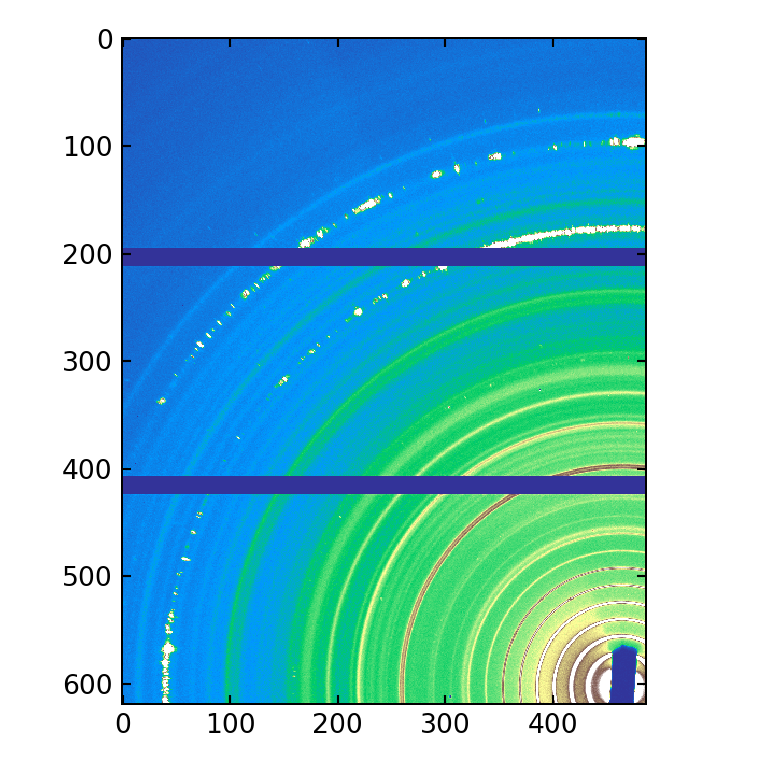

In [178]:
%matplotlib notebook

# det_shape = (619,487)

lmin, lmax = np.percentile(calib_data, (2, 99))
plt.figure(figsize=(4,4))
plt.imshow(calib_data, cmap='terrain',
           vmin=lmin, vmax=lmax,
           origin='upper')

### Beam center looks like [466, 603]

In [179]:
# NSLS-II is a photon Science CCD
# 17 keV for this calib image apparently
# nominally 190 mm

### Starting beam position
sdd_guess = 0.153
center_guess = [603, 466] # -y, +x

### Detector pixel size
det_pix = [172e-6, 172e-6]
detector = pyFAI.detectors.Detector(det_pix[0], det_pix[1])

### Wavelength
Energy = 12 #keV
wl = 3e8 * 6.63e-34 / Energy * 6.242e15 # c*h/Energy * keV/Joule = wavelength in meters

### Silver whatever calibrant
agbh = get_calibrant('AgBh')
agbh._wavelength = wl
vars(agbh)

{'_filename': '/anaconda/envs/pygix/lib/python3.6/site-packages/pyFAI/utils/../resources/calibration/AgBh.D',
 '_wavelength': 1.0346114999999999e-10,
 '_sem': <threading.Semaphore at 0x134e2ef28>,
 '_2th': [],
 '_dSpacing': []}

## Compare real calibration image to fake one

<IPython.core.display.Javascript object>


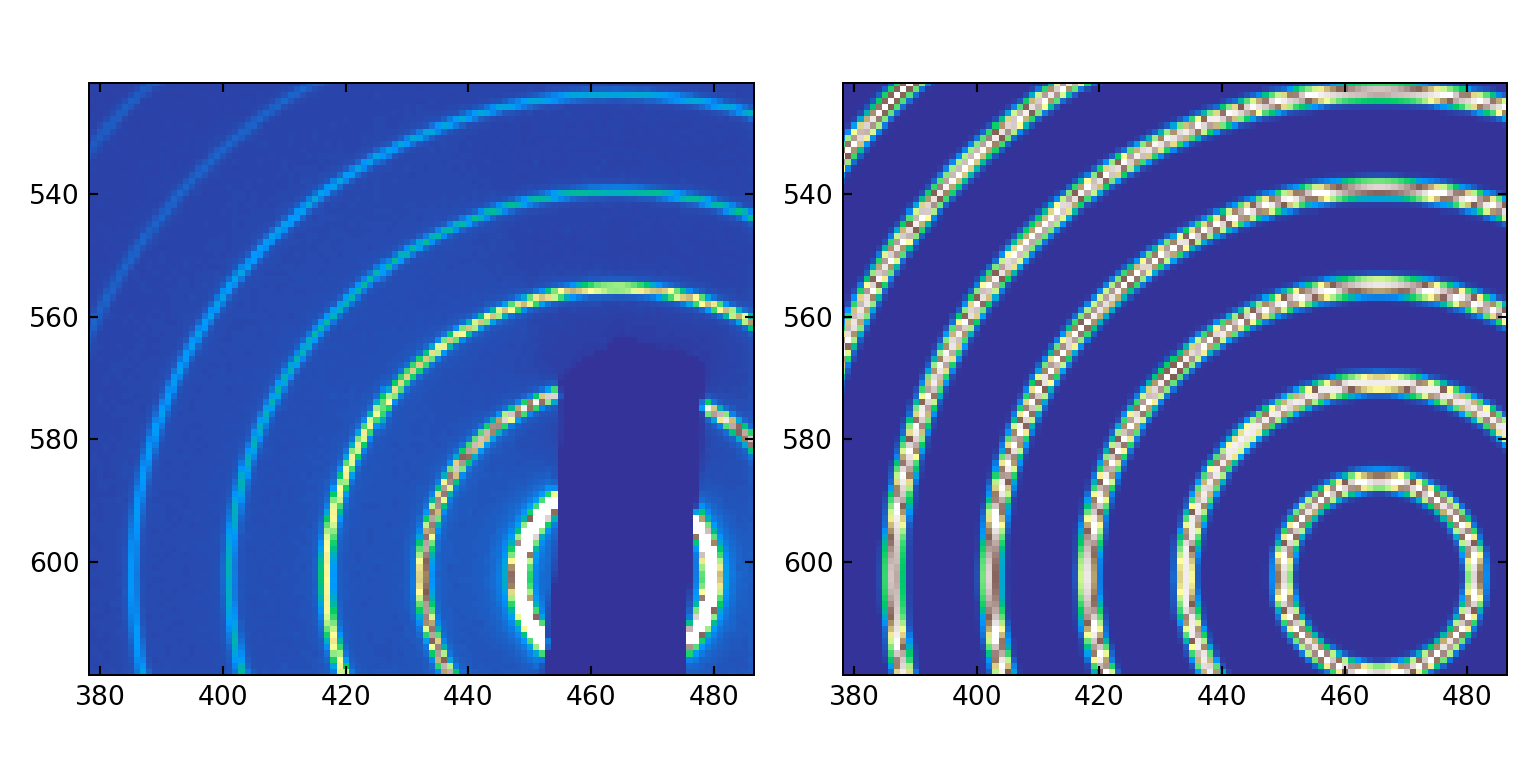

In [180]:
### Give initial guess of center location (in meters from the image origin i.e top left)
poni1_guess = center_guess[0]*det_pix[0]
poni2_guess = center_guess[1]*det_pix[1]

rot1 = 0    /180 * np.pi # move detector to right, in-plane angle# in radians
rot2 = 0    /180 * np.pi # move detector up, out-of-plane angle
rot3 = 0    /180 * np.pi # clockwise rotation

### Have to define an "azi integrator" then it can generate fake image of the calibrant
ai = pyFAI.AzimuthalIntegrator(dist=sdd_guess, poni1=poni1_guess, poni2=poni2_guess,
                               rot1=rot1, rot2=rot2, rot3=rot3,
                               detector=detector, wavelength=wl)
fake = agbh.fake_calibration_image(ai, shape = calib_data.shape, W=0.000005)

### Plot the real calibration image next to fake one
cmin, cmax = np.percentile(fake, (2, 99.9))
lmin, lmax = np.percentile(calib_data, (10, 99.9))

plt.figure(figsize=(8,4))
ax1=plt.subplot(122)
plt.imshow(fake, cmap='terrain',
           vmin=cmin, vmax=cmax,
           origin='upper')
ax2=plt.subplot(121, sharex=ax1, sharey=ax1)
plt.imshow(calib_data, cmap='terrain',
           vmin=lmin, vmax=lmax,
           origin='upper')
# plt.savefig('calib_debug\\rings.png')

## Write down coordinates of mask by zooming in on a ring section with a flat-ish background

In [181]:
mask_bounds = [525,575,390,440] # indices of a box around a ring sector: [i-, i+, j-, j+]
fg_int=8000; bg_int=1000 # approximate ring intensity, approximate bg intensity - read from graph above
fake_ring_int = 0.9; fake_bg_int = 0
scale_init = [(fg_int-bg_int)/(fake_ring_int-fake_bg_int), bg_int-(fg_int-bg_int)/(fake_ring_int-fake_bg_int)*fake_bg_int]

In [182]:
scale_init

[7777.777777777777, 1000.0]

## Define an optimizer that will fit a fake ring to a real ring
Looks like we should target the first ring, so we need to define mask bounds so we don't try to fit every ring

In [184]:
from datetime import datetime

def calib_obj_fun(x, calib_img, detector, calibrant, bb, wl, scale, W, rot1, rot2, rot3):
    
    # x: [beam_cent_y, beam_cent_x, sdd, fake_scale]
    # bb is mask bounds [-i, +i, -j, +j]
#     print(x.shape)
    
    # Set up test detector
    det_shape=calib_img.shape
    poni1 = x[0]*detector.get_pixel1()
    poni2 = x[1]*detector.get_pixel2()
    ai = pyFAI.AzimuthalIntegrator(dist=x[2], poni1=poni1, poni2=poni2,
                                   rot1=x[3], rot2=x[4], rot3=rot3,
                                   detector=detector, wavelength=wl)
    
    # Generate fake calibrant image, apply scale and background
    fake = calibrant.fake_calibration_image(ai, shape = det_shape, W=W) * scale[0] + scale[1]

    # Return the sum of the ABSOLUTE difference
    out = np.sum(np.sum(np.abs(calib_img-fake)[bb[0]:bb[1],bb[2]:bb[3]]))
    print('Residual: {}'.format(out))
    return out

def calibrate_waxs(calib_img, detector, calibrant, cent_init, sdd_init, scale_init, wl, mask_bounds,
                   rot1, rot2, rot3, W=0.000005):
    
    init_params = [cent_init[0], cent_init[1], sdd_init, rot1, rot2]
    
    args = (calib_img, detector, calibrant, mask_bounds, wl, scale_init, W, rot1, rot2, rot3)

    final_params = minimize(calib_obj_fun, init_params,
                            args=args, method='nelder-mead', tol=1e-3,
                            options={'disp':True,
                                     'maxiter':1000})
    
    return final_params

In [185]:
det_params = calibrate_waxs(calib_data, detector, agbh, center_guess, sdd_guess, scale_init, wl, mask_bounds,
                            rot1, rot2, rot3)
det_params

Residual: 2127581.6379787647
Residual: 3713080.841240162
Residual: 3205108.9478041288
Residual: 3450813.3142229393
Residual: 2066314.6346239785
Residual: 2195856.0162911825
Residual: 3212125.728126965
Residual: 3582382.5245143976
Residual: 2509461.0807264876
Residual: 3735978.0367388204
Residual: 3285768.1281793118
Residual: 2093454.4276951544
Residual: 2118199.8921410604
Residual: 2131756.6028361483
Residual: 3707869.439560118
Residual: 3544083.583919305
Residual: 3679812.928162992
Residual: 3717551.9709701436
Residual: 2079261.4862225447
Residual: 2089967.0968251922
Residual: 2032908.9232767234
Residual: 3340390.8688339395
Residual: 3649298.6185769793
Residual: 3744247.6840257193
Residual: 3091988.380199587
Residual: 3697517.58369999
Residual: 2680353.935518212
Residual: 3161479.98958458
Residual: 2501191.905634217
Residual: 3383491.8002712494
Residual: 2151184.30794113
Residual: 2030477.6392935633
Residual: 2610788.9775789124
Residual: 2273479.1602028883
Residual: 1989666.0634123648

 final_simplex: (array([[6.03317955e+02, 4.64537373e+02, 1.52394811e-01, 2.33302778e-04,
        3.42113209e-05],
       [6.03317952e+02, 4.64537369e+02, 1.52394808e-01, 2.33301575e-04,
        3.42095019e-05],
       [6.03317951e+02, 4.64537368e+02, 1.52394802e-01, 2.33301343e-04,
        3.42095274e-05],
       [6.03317955e+02, 4.64537366e+02, 1.52394809e-01, 2.33301382e-04,
        3.42093528e-05],
       [6.03317950e+02, 4.64537370e+02, 1.52394808e-01, 2.33301069e-04,
        3.42088527e-05],
       [6.03317953e+02, 4.64537367e+02, 1.52394801e-01, 2.33301547e-04,
        3.42099528e-05]]), array([1948266.24754824, 1948266.24775662, 1948266.24788332,
       1948266.24797092, 1948266.24834257, 1948266.24845458]))
           fun: 1948266.247548245
       message: 'Optimization terminated successfully.'
          nfev: 282
           nit: 146
        status: 0
       success: True
             x: array([6.03317955e+02, 4.64537373e+02, 1.52394811e-01, 2.33302778e-04,
       3.42113209e-

## Finally, build a detector based on the fitted parameters

In [186]:
dfw.loc[904]

tiff        /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...
burst                                                     NaN
exp_time                                                   10
mode                                                     maxs
sample                                      ds30cn_30_w1_pos1
stamp                                                  994732
t                                                       272.8
theta                                                    0.15
Name: 904, dtype: object

## Try a transform, see how it works

2019-02-26 08:03:47,098 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected


<IPython.core.display.Javascript object>


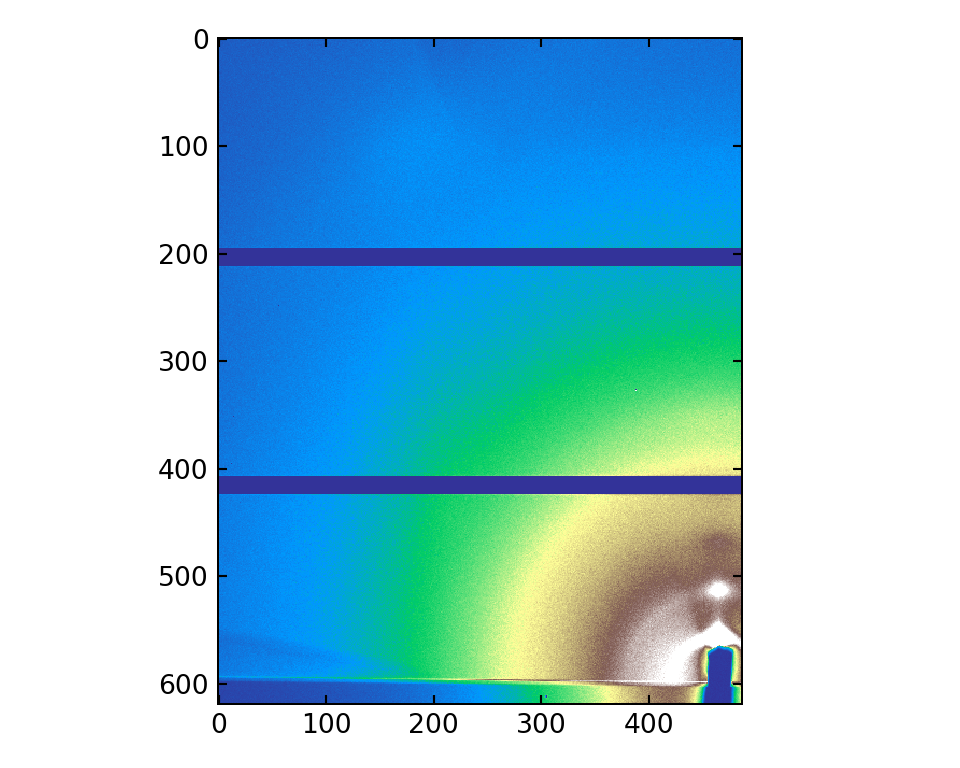

In [187]:
sample = 904

pcolor(get_data(dfw,sample), aspect='equal')

## Dump detector params to a csv

In [188]:
# Orientations and Angles
sample_orientation = 1    # 1 is horizontal, 2 is vertical
tilt_angle = 0            # tilt angle of sample in deg (misalignment in "chi")

### poni1 is the y-coordinate (in meters) on the detector where the beam hits.
### poni2 is same for x. So we take the fitted beam center in pixels and multiply by the pixel size
det_param_dict = {'det_pix': det_pix[0],
                  'wavelength': wl,
                  'poni1': det_params.x[0] * det_pix[0],
                  'poni2': det_params.x[1] * det_pix[1],
                  'dist': det_params.x[2],
                  'rot1': det_params.x[3],
                  'rot2': det_params.x[4],
                  'rot3': 180 / 180 *np.pi,
                  'sample_orientation': sample_orientation,
                  'tilt_angle': tilt_angle}

det_param_df = pd.DataFrame(det_param_dict, index=['val']).transpose().reset_index().rename(columns={'index':'param'})
det_param_df.to_csv(os.path.join(nils_dir,'calib.csv'))

In [189]:
det_param_df = pd.read_csv(os.path.join(nils_dir,'calib.csv'))
det_kwargs = dict(zip(det_param_df['param'], det_param_df['val']))
det_kwargs

{'det_pix': 0.000172,
 'dist': 0.1523948111643043,
 'poni1': 0.10377068826819774,
 'poni2': 0.07990042810956673,
 'rot1': 0.000233302777589545,
 'rot2': 3.421132088879312e-05,
 'rot3': 3.1415926535897927,
 'sample_orientation': 1.0,
 'tilt_angle': 0.0,
 'wavelength': 1.0346115e-10}

2019-02-26 08:04:01,288 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected
2019-02-26 08:04:01,341 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected
2019-02-26 08:04:01,402 - pygix.transform - INFO - pygix.Transform.transform_image: Resetting transformer because init


<IPython.core.display.Javascript object>


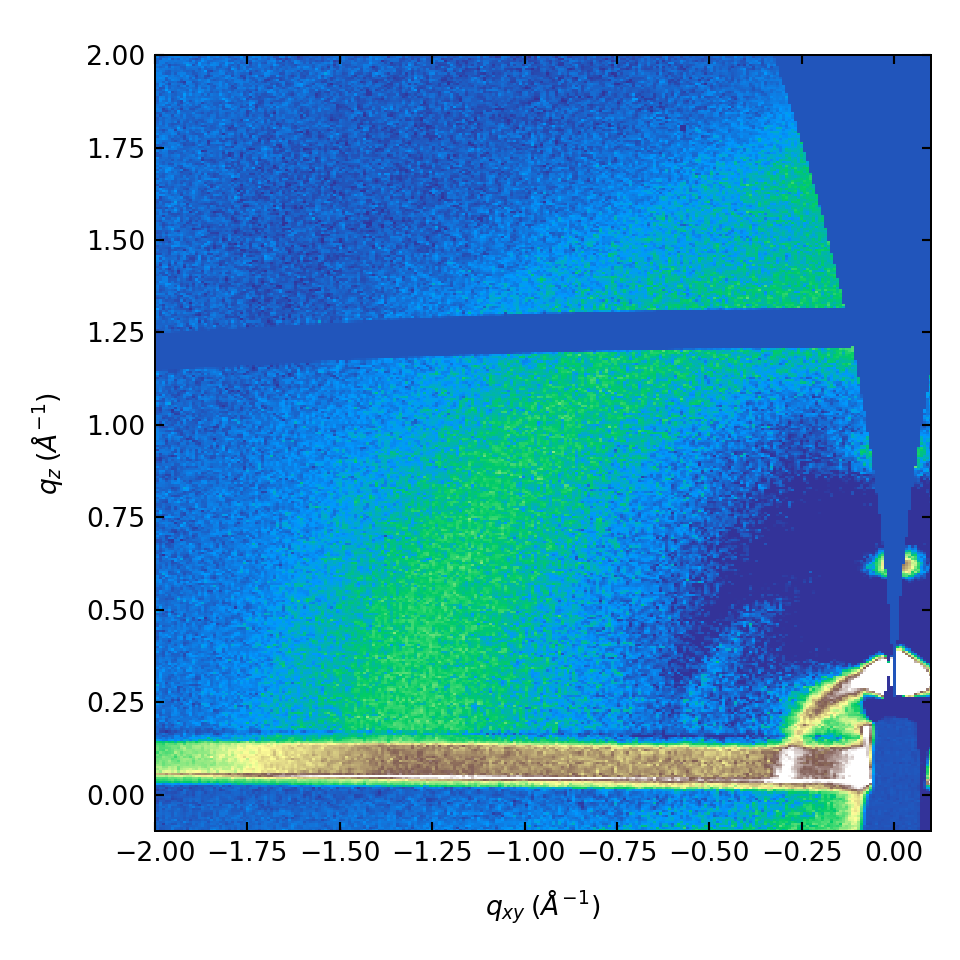

/anaconda/envs/pygix/lib/python3.6/site-packages/pygix-0.1.4a0-py3.6.egg/pygix/plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':


(<matplotlib.image.AxesImage at 0x13082ce10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13958b588>)

In [190]:
pg = setup_detector(dfw['theta'].loc[sample], os.path.join(nils_dir,'calib.csv'))
imgt, qxy, qz = pg.transform_reciprocal(get_data(dfw,sample), method='lut',
                                        correctSolidAngle=True, unit='A',
                                        dark=get_blank(dfb, dfw, sample, blank_set='test_si'))
corrimg = imgt-np.min(imgt)+1
logimg = np.log(corrimg)

clim = np.percentile(logimg[logimg>1], (2, 99.8))
plt.figure(figsize=(5,5))
ppl.implot(logimg, qxy, qz, mode='rsma',
           cmap="terrain", clim=clim,
           xlim=(-2,0.1), ylim=(-0.1,2),
           newfig=False)

In [191]:
def get_pole_figure(df, sample, calib_csv, chi_range=(-90,0), q_range=(0,2), npt=(180,180)):
    
    data = get_data(df, sample)
    theta = df.loc[sample].theta
    pg = setup_detector(theta, calib_csv)
    print(data.shape)
    
    intensity, q_abs, chi = pg.transform_polar(data, unit='A',
                                               npt=npt,
                                               chi_range=chi_range, q_range=q_range,
                                               correctSolidAngle=True,
                                               method='splitpix')
    
    return intensity, q_abs, chi

2019-02-26 08:04:20,224 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected


(619, 487)


<IPython.core.display.Javascript object>


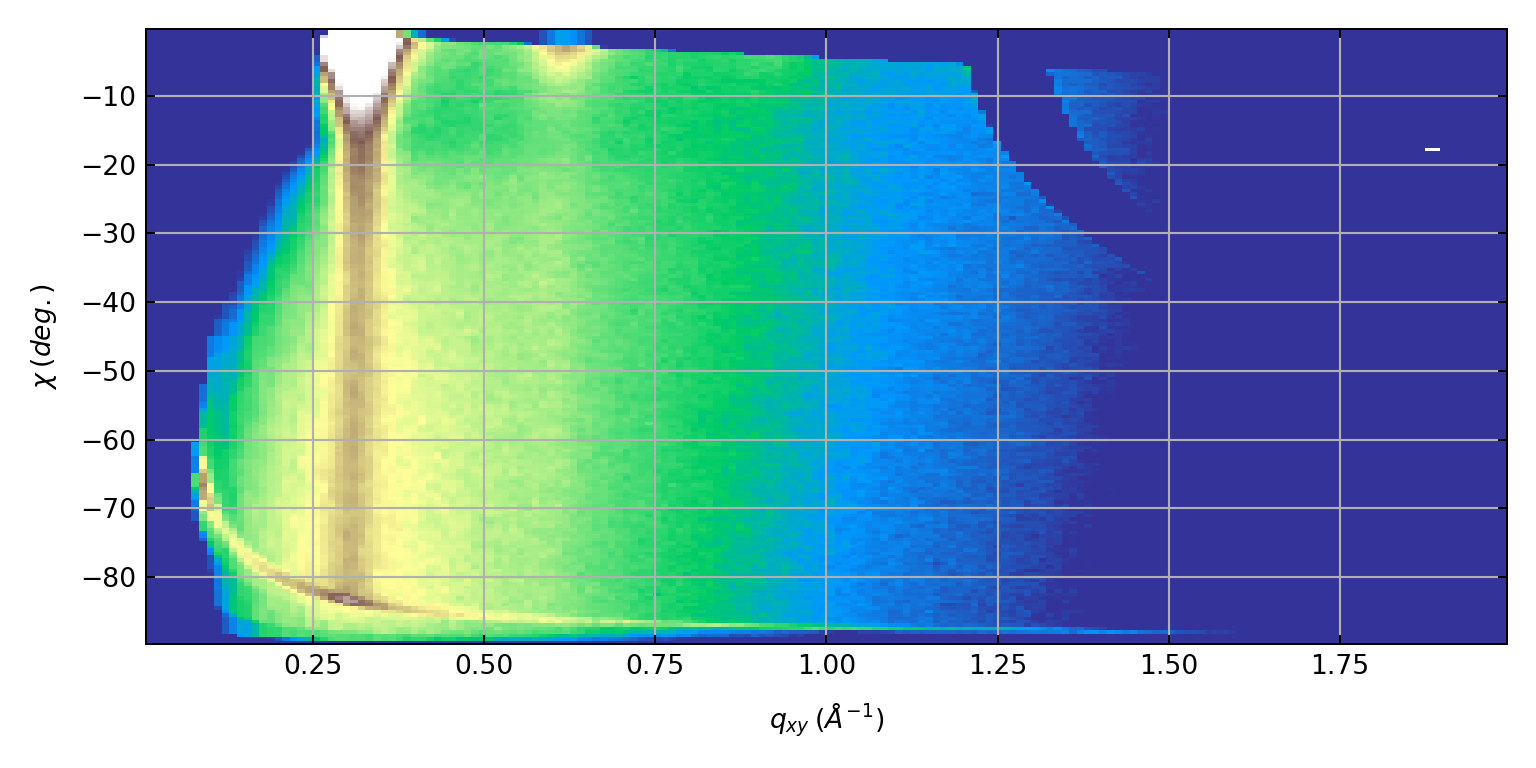

In [192]:
imgp, q_abs, chi = get_pole_figure(dfw, sample, os.path.join(nils_dir,'calib.csv'))
corrimg = imgp-np.min(imgp)+1
logimg = np.log(corrimg)

pcolor(logimg, figsize=(8,4),
       extent=[q_abs.min(), q_abs.max(), chi.min(), chi.max()],
       origin='lower', prcs=(40,99.5))
plt.xlabel(r'$q_{xy} \: (\AA^{-1})$')
plt.ylabel(r'$\chi \: (deg.)$')
plt.gca().grid(True)

## Let's add a blank

In [193]:
blank_files = glob.glob(os.path.join(nils_dir, 'blanks', '*.tiff'))
dfb = build_master_table(blank_files)
dfb

,tiff,sample,t,theta,exp_time,stamp,mode
0,/Users/nils/CC/CMS Data/Nils/insitu_air/blanks...,ahmad_blank,1010.9,0.12,30.0,993635,maxs
1,/Users/nils/CC/CMS Data/Nils/insitu_air/blanks...,ahmad_blank,1043.9,0.15,30.0,993636,maxs
2,/Users/nils/CC/CMS Data/Nils/insitu_air/blanks...,ahmad_blank,1077.0,0.21,30.0,993637,maxs
3,/Users/nils/CC/CMS Data/Nils/insitu_air/blanks...,ahmad_blank,171.8,0.05,0.5,993621,saxs
4,/Users/nils/CC/CMS Data/Nils/insitu_air/blanks...,ahmad_blank,175.9,0.08,0.5,993622,saxs
5,/Users/nils/CC/CMS Data/Nils/insitu_air/blanks...,ahmad_blank,179.9,0.10,0.5,993623,saxs
6,/Users/nils/CC/CMS Data/Nils/insitu_air/blanks...,ahmad_blank,183.9,0.12,0.5,993624,saxs
7,/Users/nils/CC/CMS Data/Nils/insitu_air/blanks...,ahmad_blank,187.9,0.15,0.5,993625,saxs
8,/Users/nils/CC/CMS Data/Nils/insitu_air/blanks...,ahmad_blank,637.0,0.08,30.0,993626,saxs
9,/Users/nils/CC/CMS Data/Nils/insitu_air/blanks...,ahmad_blank,670.1,0.10,30.0,993627,saxs


## Define a function to make a transform with these parameters

In [194]:
sample=904
dfw.loc[sample]

tiff        /Users/nils/CC/CMS Data/Nils/insitu_air/ds30cn...
burst                                                     NaN
exp_time                                                   10
mode                                                     maxs
sample                                      ds30cn_30_w1_pos1
stamp                                                  994732
t                                                       272.8
theta                                                    0.15
Name: 904, dtype: object

In [195]:
def get_blank(dfb,dfw,sample,blank_set='si_pos1'):
    """ Given a sample row from a regular df, find blank with corresponding theta and
    scale for exposure time"""
    
    dfb_filter = dfb.loc[dfb['sample']==blank_set].loc[dfb['mode']==dfw['mode'].loc[sample]]
    dfb_sorted = dfb_filter.iloc[(dfb_filter['theta']-dfw['theta'].loc[sample]).abs().argsort()]
    blank_match = dfb_sorted.index.values[0]
    blank_raw = get_data(dfb_sorted, blank_match)
    blank_scaled = blank_raw * dfw['exp_time'].loc[sample] / dfb['exp_time'].loc[blank_match]

    return blank_scaled

2019-02-26 08:04:58,107 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected


<IPython.core.display.Javascript object>


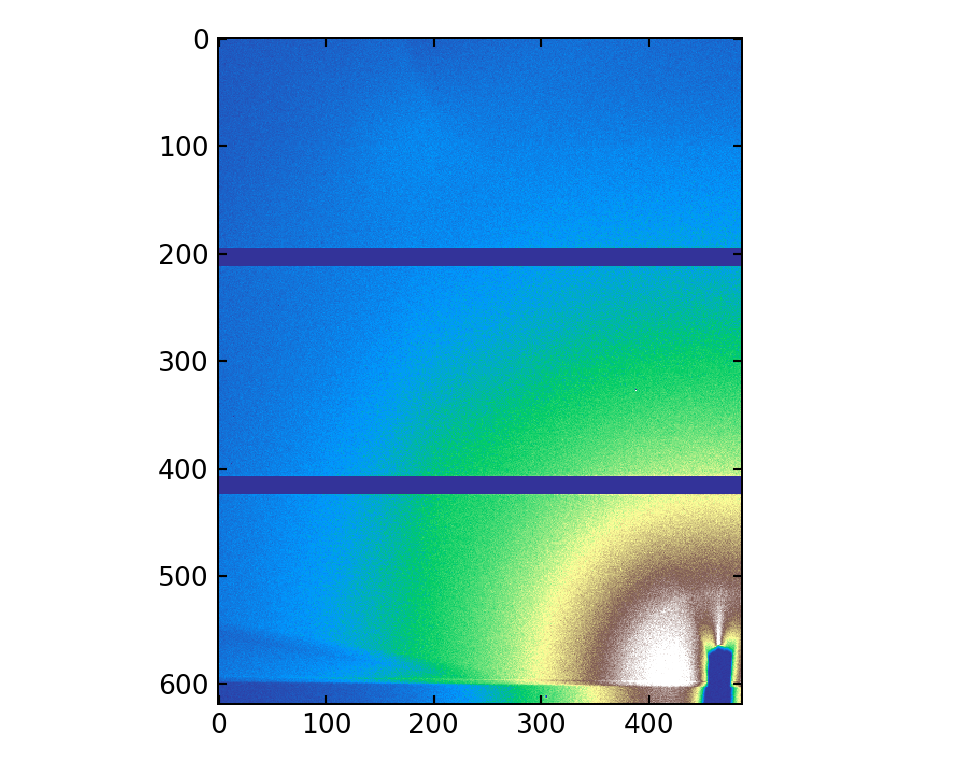

In [197]:
pcolor(get_blank(dfb,dfw,904, blank_set='si_pos1'), aspect='equal')

2019-02-26 08:05:11,655 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected
2019-02-26 08:05:11,691 - fabio.TiffIO - WARNING - Data at tag id '65000' is smaller than expected
2019-02-26 08:05:11,717 - pygix.transform - INFO - pygix.Transform.transform_image: Resetting transformer because init


<IPython.core.display.Javascript object>


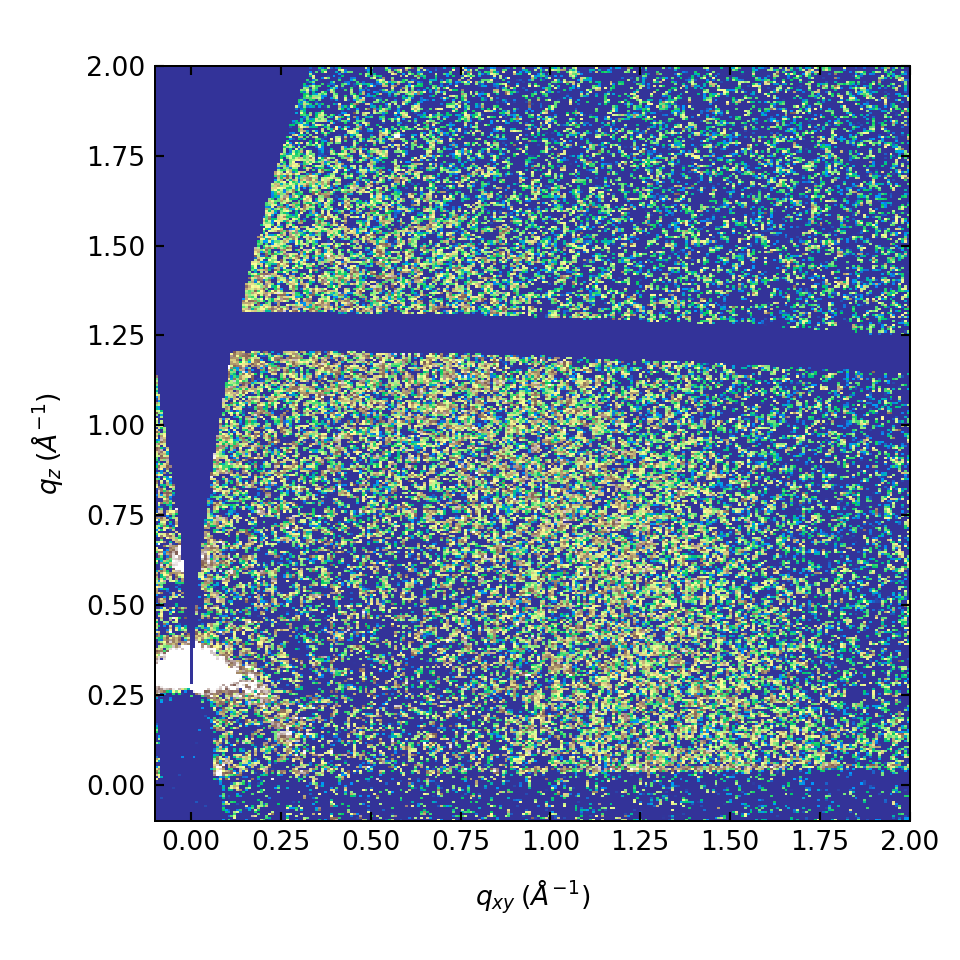

/anaconda/envs/pygix/lib/python3.6/site-packages/pygix-0.1.4a0-py3.6.egg/pygix/plotting.py:346: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif clim == 'auto':


In [199]:
samp = 800
show_sample(dfw, samp, dark=get_blank(dfb, dfw, samp, blank_set='si_pos1'))
# show_sample(dfw, samp)